# SLR data reduction: OTF under the hood

Here we disect the files (one ifproc and four roach) for an obsnum. Since an observation is typically one short **Cal** and one long **Map**, we have 10 files to process for an observation.

The **ifproc** samples at 125 Hz.  The roach boards at 10 Hz (the integration time). Each roach board has 4 beams, their timestamps are staggered, i.e. b0,b1,b2,b3,b0,b1,b2,b3,..... have incremental times at a cadence of about 0.025sec. Note that each of those are sampled independantly, thus they needs to be syncd by the software during reduction.

The information what kind of data the telescope is taking is in the **ifproc::BufPos** variable, and takes up four values:
* 0 = "on"
* 1 = "ref"
* 2 = "sky"
* 3 = "hot"

The **Cal** is two short 2.1" bursts of "Hot" and "Sky", with a 2.5" switch time.   The **Map** are many repetitions of "Ref" and "On". For the IRC benchmark data of ~700" there are five "Ref" and four "On". Slewing is about 7-8".  Switching from "Cal" to "Map" is about 14". Each "Ref" is about 10", each "On" about 143"
  
    ObsPgm: <- Cal ->     <------------------- Map ----------------------->
      type:   H s S        s  R s  O  s  R s  O  s  R s  O  s  R s  O  s  R
      time:   2 3 2       14 10 8 143 8 10 8 143 8 10 8 143 8 10 8 143 8 10
      H=hot S=sky R=ref O=on s=slew/switch
    
In this observation, the integration time was 4x143 = 572", the total run was 708", thus an 81% observing efficiency.

The **Header.Dcs.IntegrationTime = 528.4** differs from this timing analysis, which suggests 572".  Is there dead-time between integrations?   If so, then the observing efficiency is 75% for the benchmark.
    

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as pl

import netCDF4
import datetime

from lmtslr.spec import *
from lmtslr.ifproc import *
from lmtslr.viewer.spec_viewer import *
#from beam import *
#from beam_viewer import *
from lmtslr.utils.roach_file_utils import create_roach_list, lookup_roach_files
from lmtslr.utils.ifproc_file_utils import lookup_ifproc_file

from lmtslr.ifproc.ifproc import IFProcData, IFProcCal
from lmtslr.spec.spec import SpecBankCal, SpecBankData

from lmtslr.utils.reader import read_obsnum_ps

testing TKAgg
use() got an unexpected keyword argument 'warn'
testing Agg
use() got an unexpected keyword argument 'warn'
testing GTKAgg
use() got an unexpected keyword argument 'warn'
testing Qt4Agg
use() got an unexpected keyword argument 'warn'
testing WXAgg
use() got an unexpected keyword argument 'warn'


In [2]:
# set root directory for the benchmark IRC_data
path = os.environ['DATA_LMT'] + '/../IRC_data'
       
# set obsnum for cal (0) and map (1)     
obsnum0 = 79447
obsnum1 = 79448

# get the filenames associated with these obsnums                                                                        
iffile0   = lookup_ifproc_file(obsnum0,path=path+'/ifproc')
rofile0,n = lookup_roach_files(obsnum0,path=path+'/spectrometer')

iffile1   = lookup_ifproc_file(obsnum1,path=path+'/ifproc')
rofile1,n = lookup_roach_files(obsnum1,path=path+'/spectrometer')


In [3]:
print(path)
print(iffile0)
print(iffile1)

/media/teuben/P1-2/teuben/LMT/lmt_data/../IRC_data
/media/teuben/P1-2/teuben/LMT/lmt_data/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc
/media/teuben/P1-2/teuben/LMT/lmt_data/../IRC_data/ifproc/ifproc_2018-11-16_079448_01_0000.nc


In [4]:
def date_obs(date):
    """ convert to ISO """
    return datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%dT%H:%M:%S')
    

In [5]:
def get_ifproc(filename):
    """ get some header info from an ifproc file"""
    
    nc = netCDF4.Dataset(filename)
    
    bufpos = nc.variables['Data.TelescopeBackend.BufPos'][:]
    dates  = nc.variables['Data.TelescopeBackend.TelTime'][:]
    date0   = date_obs(dates[0])
    date1   = date_obs(dates[-1])
    tsky    = dates[-1] - dates[0]
    sname = filename[filename.rfind('/')+1:]
    
    cnt = []
    for b in [0,1,2,3]:
        idx = np.where(bufpos==b)
        cnt.append(len(idx[0]))
    print(sname,date0,date1,int(tsky),cnt)   
    
    nc.close()

In [6]:
def get_roach(filename):
    """ get some roach board info """
    
    nc = netCDF4.Dataset(filename)
    
    dates = nc.variables['Data.Integrate.time'][:]
    date0   = date_obs(dates[0])
    date1   = date_obs(dates[-1])
    tsky    = dates[-1] - dates[0]
    sname   = filename[filename.rfind('/')+1:]
    nsky = len(dates)
    print(sname,date0,date1,int(tsky),nsky)  
    
    nc.close()

In [7]:
get_ifproc(iffile0)
get_ifproc(iffile1)
for f in rofile0:
    get_roach(f)    
for f in rofile1:
    get_roach(f)

ifproc_2018-11-16_079447_00_0001.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 [0, 0, 265, 263]
ifproc_2018-11-16_079448_01_0000.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 685 [57349, 5108, 0, 0]
roach0_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 236
roach1_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 236
roach2_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 240
roach3_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 8 244
roach0_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25108
roach1_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25112
roach2_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25140
roach3_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25144


###    Detailed look at time

By plotting the time we can see slewing (for the Map, about 7-8") and switching hot/sky (for the Cal, about 2.5").

In [8]:
def get_dates(filename,varname):
    nc = netCDF4.Dataset(filename)
    dates  = nc.variables[varname][:]
    nc.close()
    return dates

In [9]:
if True:
    dates0 = get_dates(iffile0,'Data.TelescopeBackend.TelTime')
    dates1 = get_dates(iffile1,'Data.TelescopeBackend.TelTime')
else:
    dates0 = get_dates(rofile0[0],'Data.Integrate.time')
    dates1 = get_dates(rofile1[0],'Data.Integrate.time')   
dates2 = np.append(dates0,dates1)

    


0.00800013542175293
0.040000200271606445
708.210000038147


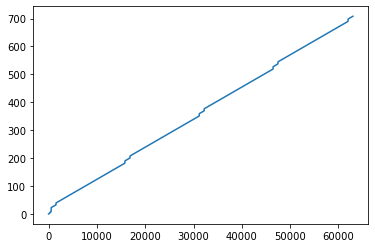

In [10]:
dates = dates2 - dates2[0]
pl.plot(range(len(dates)),dates);
print(dates[1]-dates[0])
print(dates[4]-dates[0])
print(dates[-1]-dates[0])

In [11]:
#   find the times where a jump occured
x=dates[1:]-dates[:-1]
idx = np.where(x>0.1)
d = dates[idx]
y=d[1:]-d[:-1]

In [12]:
# print out the times of the jumps
t = 0
n = 1
for i in idx[0]:
    dt = dates[i]-t
    print("%2d %6.1f %6.1f" % (n,t,dt))
    n = n + 1
    t = dates[i]
    dt = dates[i+1]-t
    print("%2d %6.1f %6.1f" % (n,t,dt))
    t = dates[i+1]
    n = n + 1
dt = dates[-1]-t
print("%2d %6.1f %6.1f" % (n,t,dt))

 1    0.0    2.6
 2    2.6    2.5
 3    5.1    2.6
 4    7.7   14.7
 5   22.4   10.1
 6   32.5    6.8
 7   39.3  142.5
 8  181.8    8.1
 9  189.9   10.6
10  200.4    7.1
11  207.6  143.3
12  350.8    8.3
13  359.1   10.1
14  369.3    7.2
15  376.5  142.6
16  519.1    8.3
17  527.4   10.1
18  537.5    7.3
19  544.8  145.0
20  689.7    8.3
21  698.1   10.1
